# Preprocessing danych

In [30]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [31]:
money = 100000
debt = 250000

print("cheap: ", 0, " - ",money)
print("average: ", money, " - ", debt+money)
print("expensive: ", debt+money, " - ", "inf")

cheap:  0  -  100000
average:  100000  -  350000
expensive:  350000  -  inf


# Initial data viewing

In [32]:
# load data from csv
with open('zadanie_studenci/train_data.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)


df = pd.DataFrame(data[1:], columns=data[0])

# check for missing values
missing_values = df.isnull().sum()
print(missing_values)

SalePrice                    0
YearBuilt                    0
Size(sqf)                    0
Floor                        0
HallwayType                  0
HeatingType                  0
AptManageType                0
N_Parkinglot(Ground)         0
N_Parkinglot(Basement)       0
TimeToBusStop                0
TimeToSubway                 0
N_manager                    0
N_elevators                  0
SubwayStation                0
N_FacilitiesInApt            0
N_FacilitiesNearBy(Total)    0
N_SchoolNearBy(Total)        0
dtype: int64


In [33]:
df.describe()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
count,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124
unique,841,16,89,43,3,2,2,23,20,3,5,9,13,8,9,11,14
top,176991,2007,914,4,terraced,individual_heating,management_in_trust,67.0,536.0,0~5min,0-5min,6.0,0.0,Kyungbuk_uni_hospital,4,9.0,17.0
freq,38,881,683,228,2485,3938,3869,512,690,3148,1960,1017,735,1125,1003,1493,824


In [34]:
idx = data[0].index("N_Parkinglot(Ground)")
print("N_Parkinglot(Ground): ", data[1][idx], data[2][idx], data[3][idx])

print(data[1][idx].split(".")[1] != '0')
print(data[1][idx].isdigit())

N_Parkinglot(Ground):  111.0 80.0 80.0
False
False


In [35]:
columns_with_types = {}

for column in df.columns:
    numeric_series = pd.to_numeric(df[column], errors='coerce')

    if not numeric_series.isna().any():
        if (numeric_series == numeric_series.astype(int)).all():
            print(f"{column} has type: int")
            columns_with_types[column] = "int"
        else:
            print(f"{column} has type: float")
            columns_with_types[column] = "float"
    else:
        print(f"{column} has type: string")
        columns_with_types[column] = "string"


SalePrice has type: int
YearBuilt has type: int
Size(sqf) has type: int
Floor has type: int
HallwayType has type: string
HeatingType has type: string
AptManageType has type: string
N_Parkinglot(Ground) has type: int
N_Parkinglot(Basement) has type: int
TimeToBusStop has type: string
TimeToSubway has type: string
N_manager has type: int
N_elevators has type: int
SubwayStation has type: string
N_FacilitiesInApt has type: int
N_FacilitiesNearBy(Total) has type: int
N_SchoolNearBy(Total) has type: int


In [36]:
columns_with_types

{'SalePrice': 'int',
 'YearBuilt': 'int',
 'Size(sqf)': 'int',
 'Floor': 'int',
 'HallwayType': 'string',
 'HeatingType': 'string',
 'AptManageType': 'string',
 'N_Parkinglot(Ground)': 'int',
 'N_Parkinglot(Basement)': 'int',
 'TimeToBusStop': 'string',
 'TimeToSubway': 'string',
 'N_manager': 'int',
 'N_elevators': 'int',
 'SubwayStation': 'string',
 'N_FacilitiesInApt': 'int',
 'N_FacilitiesNearBy(Total)': 'int',
 'N_SchoolNearBy(Total)': 'int'}

In [37]:
numerical_columns = []
categorical_columns = []

for column, _type in columns_with_types.items():
    if _type == "int" or _type == "float":
        numerical_columns.append(column)
    else:
        categorical_columns.append(column)

print("Numerical columns: ", numerical_columns)
print("Categorical columns: ", categorical_columns)

Numerical columns:  ['SalePrice', 'YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Ground)', 'N_Parkinglot(Basement)', 'N_manager', 'N_elevators', 'N_FacilitiesInApt', 'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
Categorical columns:  ['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation']


In [38]:
# convert numerical columns to int
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric, errors='coerce')

In [39]:
for colm in categorical_columns:
    value_counts = df[colm].value_counts()
    print(f"{colm} has unique values: {value_counts.to_dict()}")

HallwayType has unique values: {'terraced': 2485, 'mixed': 1194, 'corridor': 445}
HeatingType has unique values: {'individual_heating': 3938, 'central_heating': 186}
AptManageType has unique values: {'management_in_trust': 3869, 'self_management': 255}
TimeToBusStop has unique values: {'0~5min': 3148, '5min~10min': 938, '10min~15min': 38}
TimeToSubway has unique values: {'0-5min': 1960, '5min~10min': 792, '15min~20min': 682, '10min~15min': 526, 'no_bus_stop_nearby': 164}
SubwayStation has unique values: {'Kyungbuk_uni_hospital': 1125, 'Myung-duk': 1065, 'Banwoldang': 531, 'Bangoge': 512, 'Sin-nam': 468, 'no_subway_nearby': 276, 'Chil-sung-market': 85, 'Daegu': 62}


In [40]:
df['SalePrice'] = df['SalePrice'].astype(int)

min_target = df['SalePrice'].min()
max_target = df['SalePrice'].max()

def categorize_target(value):
    if value < money:
        return 0
    elif value < debt + money:
        return 1
    else:
        return 2

df['price_category'] = df['SalePrice'].apply(categorize_target)
df.drop(columns=['SalePrice'], inplace=True)

target_counts = df['price_category'].value_counts().to_dict()

print("Target counts: ", target_counts)
print("Max target: ", max_target)
print("Min target: ", min_target)

Target counts:  {1: 2998, 2: 570, 0: 556}
Max target:  585840
Min target:  34070


# With this knowledge we start data preprocessing

- Plan is like this: for now to leave the numerical vals as they are and to just convert the data to ints
- for coulumns TimeToBusStop, TimeToSubway do index encoding, as is thinkt that actually it will be good for the model to have a correlation that 10-15 minutes is closer to 5-10mins then 0-5 mins
- turn year built to years old

# Label encoding

In [41]:
idx_bus_stop = data[0].index("TimeToBusStop")
idx_subway = data[0].index("TimeToSubway")
idx_heating = data[0].index("HeatingType")
idx_apt_manage = data[0].index("AptManageType")

# TimeToBusStop encoding
bus_stop_mapping_str_to_int = {"0~5min": 3, "5min~10min": 2, "10min~15min": 1}
bus_stop_mapping_int_to_str = {v: k for k, v in bus_stop_mapping_str_to_int.items()}

# TimeToSubway encoding
subway_mapping_str_to_int = {"no_bus_stop_nearby": 0, "0-5min": 4, "5min~10min": 3, "10min~15min": 2, "15min~20min": 1}
subway_mapping_int_to_str = {v: k for k, v in subway_mapping_str_to_int.items()}

# HeatingType encoding (binary)
heat_mapping_str_to_int = {"individual_heating": 1, "central_heating": 0}
heat_mapping_int_to_str = {v: k for k, v in heat_mapping_str_to_int.items()}

# AptManageType encoding (binary)
apt_mapping_str_to_int = {"management_in_trust": 1, "self_management": 0}
apt_mapping_int_to_str = {v: k for k, v in apt_mapping_str_to_int.items()}

# Apply encoding to the pandas dataframe
df['TimeToBusStop'] = df['TimeToBusStop'].map(bus_stop_mapping_str_to_int)
df['TimeToSubway'] = df['TimeToSubway'].map(subway_mapping_str_to_int)
df['HeatingType'] = df['HeatingType'].map(heat_mapping_str_to_int)
df['AptManageType'] = df['AptManageType'].map(apt_mapping_str_to_int)

# Check the updated dataframe
print(df[['TimeToBusStop', 'TimeToSubway', 'HeatingType', 'AptManageType']].head())

# Verify the change has been applied correctly
print("Unique values in TimeToBusStop:", df['TimeToBusStop'].unique())
print("Unique values in TimeToSubway:", df['TimeToSubway'].unique())
print("Unique values in HeatingType:", df['HeatingType'].unique())
print("Unique values in AptManageType:", df['AptManageType'].unique())

   TimeToBusStop  TimeToSubway  HeatingType  AptManageType
0              2             2            1              1
1              3             3            1              0
2              3             3            1              0
3              3             4            1              1
4              2             1            1              0
Unique values in TimeToBusStop: [2 3 1]
Unique values in TimeToSubway: [2 3 4 1 0]
Unique values in HeatingType: [1 0]
Unique values in AptManageType: [1 0]


In [42]:
df.describe(include='all')

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),price_category
count,4124.000000,4124.000000,4124.000000,4124,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124,4124.000000,4124.000000,4124.000000,4124.000000
unique,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,terraced,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kyungbuk_uni_hospital,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1125,NaN,NaN,NaN,NaN
mean,2002.977934,959.958778,11.994665,NaN,0.954898,0.938167,192.789040,572.857662,2.754122,2.897672,6.313773,11.055771,NaN,5.824200,9.860330,10.872696,1.003395
std,8.765838,384.548456,7.581330,NaN,0.207553,0.240882,215.455916,408.179957,0.451553,1.269697,3.224556,7.717030,NaN,2.344331,3.444848,4.427445,0.522581
min,1978.000000,135.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000
25%,1993.000000,644.000000,6.000000,NaN,1.000000,1.000000,11.000000,184.000000,3.000000,2.000000,5.000000,5.000000,NaN,4.000000,8.000000,7.000000,1.000000
50%,2006.000000,910.000000,11.000000,NaN,1.000000,1.000000,100.000000,536.000000,3.000000,3.000000,6.000000,11.000000,NaN,5.000000,9.000000,10.000000,1.000000
75%,2007.000000,1160.000000,17.000000,NaN,1.000000,1.000000,249.000000,798.000000,3.000000,4.000000,8.000000,16.000000,NaN,7.000000,13.000000,15.000000,1.000000


In [43]:
# turn year build to age
df['YearBuilt'] = 2015 - df['YearBuilt']

In [44]:
df.describe(include='all')

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),price_category
count,4124.000000,4124.000000,4124.000000,4124,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124,4124.000000,4124.000000,4124.000000,4124.000000
unique,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,terraced,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kyungbuk_uni_hospital,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1125,NaN,NaN,NaN,NaN
mean,12.022066,959.958778,11.994665,NaN,0.954898,0.938167,192.789040,572.857662,2.754122,2.897672,6.313773,11.055771,NaN,5.824200,9.860330,10.872696,1.003395
std,8.765838,384.548456,7.581330,NaN,0.207553,0.240882,215.455916,408.179957,0.451553,1.269697,3.224556,7.717030,NaN,2.344331,3.444848,4.427445,0.522581
min,0.000000,135.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000
25%,8.000000,644.000000,6.000000,NaN,1.000000,1.000000,11.000000,184.000000,3.000000,2.000000,5.000000,5.000000,NaN,4.000000,8.000000,7.000000,1.000000
50%,9.000000,910.000000,11.000000,NaN,1.000000,1.000000,100.000000,536.000000,3.000000,3.000000,6.000000,11.000000,NaN,5.000000,9.000000,10.000000,1.000000
75%,22.000000,1160.000000,17.000000,NaN,1.000000,1.000000,249.000000,798.000000,3.000000,4.000000,8.000000,16.000000,NaN,7.000000,13.000000,15.000000,1.000000


In [45]:
# one hot encode HallwayType and SubwayStation
df = pd.get_dummies(df, columns=['HallwayType', 'SubwayStation'])

bool_columns = df.select_dtypes(include=['bool']).columns.tolist()
df[bool_columns] = df[bool_columns].astype(int)

In [46]:
df.describe(include='all')

,YearBuilt,Size(sqf),Floor,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,...,HallwayType_mixed,HallwayType_terraced,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
count,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,...,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000
mean,12.022066,959.958778,11.994665,0.954898,0.938167,192.789040,572.857662,2.754122,2.897672,6.313773,...,0.289525,0.602570,0.124151,0.128758,0.020611,0.015034,0.272793,0.258244,0.113482,0.066925
std,8.765838,384.548456,7.581330,0.207553,0.240882,215.455916,408.179957,0.451553,1.269697,3.224556,...,0.453597,0.489426,0.329794,0.334973,0.142096,0.121703,0.445450,0.437722,0.317220,0.249923
min,0.000000,135.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,644.000000,6.000000,1.000000,1.000000,11.000000,184.000000,3.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,910.000000,11.000000,1.000000,1.000000,100.000000,536.000000,3.000000,3.000000,6.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22.000000,1160.000000,17.000000,1.000000,1.000000,249.000000,798.000000,3.000000,4.000000,8.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,37.000000,2337.000000,43.000000,1.000000,1.000000,713.000000,1321.000000,3.000000,4.000000,14.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
numerical_columns.remove('SalePrice')

In [48]:
target = df['price_category']
data = df.drop(columns=['price_category'])

In [49]:
train_indices = np.random.rand(len(data))>0.2

train_data = data[train_indices]
train_target = target[train_indices]

test_data = data[~train_indices]
test_target = target[~train_indices]

# normalize the data
- test_set the same as train set so that there is no data leakage

In [ ]:
# normalize data
scaler = MinMaxScaler() # with standard scaler about 2 less acc on val data
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

/tmp/ipykernel_35909/630528182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
/tmp/ipykernel_35909/630528182.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])


In [51]:
train_data.describe(include='all')

,YearBuilt,Size(sqf),Floor,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,...,HallwayType_mixed,HallwayType_terraced,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
count,3326.000000,3326.000000,3326.000000,3326.000000,3326.000000,3326.000000,3326.000000,3326.000000,3326.000000,3326.000000,...,3326.000000,3326.000000,3326.000000,3326.000000,3326.000000,3326.000000,3326.000000,3326.000000,3326.000000,3326.000000
mean,0.325771,0.374574,0.262470,0.953999,0.938966,0.271900,0.435478,2.754360,2.896272,0.412114,...,0.290138,0.603428,0.121768,0.127781,0.020746,0.014432,0.273301,0.262477,0.112748,0.066747
std,0.237370,0.173709,0.180394,0.209519,0.239429,0.303294,0.310676,0.451668,1.270985,0.249799,...,0.453894,0.489259,0.327067,0.333896,0.142553,0.119280,0.445721,0.440047,0.316332,0.249621
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.216216,0.231153,0.119048,1.000000,1.000000,0.015428,0.139288,3.000000,2.000000,0.307692,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.243243,0.351953,0.238095,1.000000,1.000000,0.140252,0.405753,3.000000,3.000000,0.384615,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.594595,0.460490,0.380952,1.000000,1.000000,0.349229,0.604088,3.000000,4.000000,0.538462,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
test_data.describe(include='all')

,YearBuilt,Size(sqf),Floor,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,...,HallwayType_mixed,HallwayType_terraced,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
count,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,...,798.000000,798.000000,798.000000,798.000000,798.00000,798.000000,798.000000,798.000000,798.000000,798.000000
mean,0.321378,0.374918,0.258891,0.958647,0.934837,0.264103,0.426056,2.753133,2.903509,0.394737,...,0.286967,0.598997,0.134085,0.132832,0.02005,0.017544,0.270677,0.240602,0.116541,0.067669
std,0.235121,0.178558,0.181065,0.199231,0.246968,0.297608,0.301949,0.451357,1.265095,0.240230,...,0.452630,0.490409,0.340958,0.339606,0.14026,0.131369,0.444588,0.427717,0.321074,0.251335
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.189189,0.231153,0.119048,1.000000,1.000000,0.020337,0.139288,3.000000,2.000000,0.307692,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.243243,0.351953,0.238095,1.000000,1.000000,0.126227,0.405753,3.000000,3.000000,0.384615,...,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.594595,0.465486,0.380952,1.000000,1.000000,0.349229,0.604088,3.000000,4.000000,0.538462,...,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
train_data = torch.tensor(train_data.values, dtype=torch.float32)
train_target = torch.tensor(train_target.values, dtype=torch.int64)

test_data = torch.tensor(test_data.values, dtype=torch.float32)
test_target = torch.tensor(test_target.values, dtype=torch.int64)

train_dataset = torch.utils.data.TensorDataset(train_data, train_target)
test_dataset = torch.utils.data.TensorDataset(test_data, test_target)

In [54]:
class Adults_classifier(nn.Module):
    def __init__(self):
        super(Adults_classifier, self).__init__()
        self.layer1 = nn.Linear(train_data.shape[1], 40)
        self.act_1 = nn.LeakyReLU()
        self.d1 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(40, 20)
        self.act_2 = nn.LeakyReLU()
        self.d2 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(20, 3)
    def forward(self, x, cat_x):
        x = torch.cat([x,cat_x],dim=1)
        activation1 = self.act_1(self.layer1(x))
        activation1 = self.d1(activation1)
        activation2 = self.act_2(self.layer2(activation1))
        activation2 = self.d1(activation2)
        output = self.layer3(activation2)
        return output

In [55]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval() #*********#
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        pred = output>0
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]
    return correct / total

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [57]:
model = Adults_classifier().to(device)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(100):
    epoch_losses = []
    for data_batch, target_batch in train_loader:
        data_batch = data_batch.float().to(device)
        target_batch = target_batch.long().to(device)
        model.train()

        outputs = model(data_batch, torch.zeros(data_batch.size(0), 0).to(device))
        loss = criterion(outputs, target_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)

    model.eval()
    with torch.no_grad():
        correct_train = 0
        total_train = 0
        for data_batch, target_batch in train_loader:
            data_batch = data_batch.float().to(device)
            target_batch = target_batch.long().to(device)
            outputs = model(data_batch, torch.zeros(data_batch.size(0), 0).to(device))
            _, predicted = torch.max(outputs.data, 1)
            total_train += target_batch.size(0)
            correct_train += (predicted == target_batch).sum().item()
        train_accuracy = correct_train / total_train

        correct_test = 0
        total_test = 0
        for data_batch, target_batch in test_loader:
            data_batch = data_batch.float().to(device)
            target_batch = target_batch.long().to(device)
            outputs = model(data_batch, torch.zeros(data_batch.size(0), 0).to(device))
            _, predicted = torch.max(outputs.data, 1)
            total_test += target_batch.size(0)
            correct_test += (predicted == target_batch).sum().item()
        test_accuracy = correct_test / total_test

    train_acc.append(train_accuracy)
    val_acc.append(test_accuracy)

    print(f"Epoch {n} loss {loss_mean:.3f} train_acc: {train_accuracy:.3f} test_acc: {test_accuracy:.3f}")

print("Final Training Accuracy: {:.3f}".format(train_acc[-1]))
print("Final Validation Accuracy: {:.3f}".format(val_acc[-1]))

Epoch 0 loss 0.933 train_acc: 0.725 test_acc: 0.736
Epoch 1 loss 0.791 train_acc: 0.725 test_acc: 0.736
Epoch 2 loss 0.705 train_acc: 0.725 test_acc: 0.736
Epoch 3 loss 0.642 train_acc: 0.754 test_acc: 0.763
Epoch 4 loss 0.587 train_acc: 0.766 test_acc: 0.769
Epoch 5 loss 0.552 train_acc: 0.774 test_acc: 0.781
Epoch 6 loss 0.529 train_acc: 0.807 test_acc: 0.805
Epoch 7 loss 0.528 train_acc: 0.798 test_acc: 0.801
Epoch 8 loss 0.499 train_acc: 0.812 test_acc: 0.808
Epoch 9 loss 0.502 train_acc: 0.829 test_acc: 0.821
Epoch 10 loss 0.480 train_acc: 0.827 test_acc: 0.818
Epoch 11 loss 0.471 train_acc: 0.838 test_acc: 0.832
Epoch 12 loss 0.462 train_acc: 0.838 test_acc: 0.828
Epoch 13 loss 0.461 train_acc: 0.835 test_acc: 0.828
Epoch 14 loss 0.436 train_acc: 0.839 test_acc: 0.830
Epoch 15 loss 0.444 train_acc: 0.839 test_acc: 0.835
Epoch 16 loss 0.436 train_acc: 0.839 test_acc: 0.832
Epoch 17 loss 0.421 train_acc: 0.845 test_acc: 0.841
Epoch 18 loss 0.435 train_acc: 0.848 test_acc: 0.841
Epo

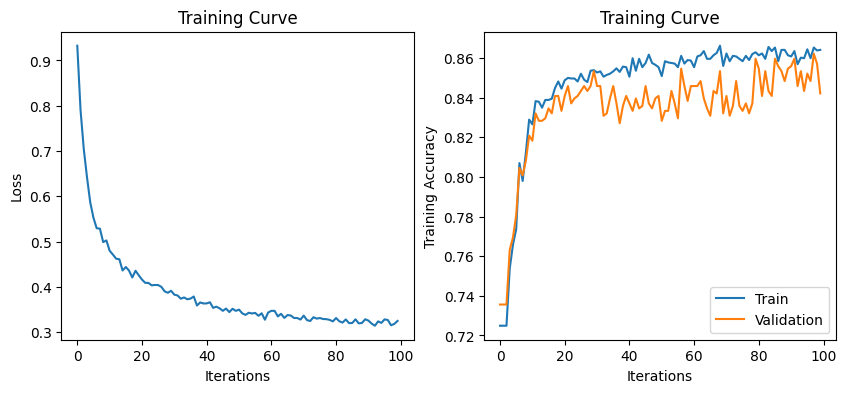

In [58]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

# co jeszcze dodac?
- koniec notebooka lab4 - wagi do przykładów
- inny preprocessing danych jak sie bedzie chciało
- model nie przekopiowany z notebooka z labów
- eksperymentacja z optymizerem
- embedding jak sie bedzie chciało
- walka z przeuczeniem, bachnorm, regularization, weight decay itd.